In [115]:
"""
AUTHOR: Shihao Zhang
Date: 10/24/2018

What is this script for?
This script can process raw data from ZenDesk by:
1. Train classifiers with labeled HVAC tickets
2. Classify tickets without label

How to use this script?
Prepare a excel file. Here is the preparation instruction:
1. 

Package required:
pandas, numpy, skilearn
"""

# Itâ€™s --> It's

'\nAUTHOR: Shihao Zhang\nDate: 10/24/2018\n\nWhat is this script for?\nThis script can process raw data from ZenDesk by:\n1. Train classifiers with labeled HVAC tickets\n2. Classify tickets without label\n\nHow to use this script?\nPrepare a excel file. Here is the preparation instruction:\n1. \n2. The first column must be time stamp\n\nPackage required:\npandas, numpy, skilearn\n'

In [116]:
import pandas as pd
import numpy as np
import datetime as dt
"""
USER INPUT
"""
path_train = "tickets(US_2018Oct29).csv" 
cols_train = [ "Created","Description","Label", "Label_id","Requester_Name",'Assignee_Name']


In [182]:
pd.set_option('display.max_rows', 25)
#pd.set_option('max_colwidth',40)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [118]:
"""
Dataset Preparation
"""

if __name__ == "__main__":
    # CSV file should be in ASCII encoding
    data = pd.read_csv(path_train,usecols=cols_train)

data.head()

Label_id_df = data[['Label', 'Label_id']].drop_duplicates().sort_values('Label_id')
Label_to_id = dict(Label_id_df.values)
id_to_Label = dict(Label_id_df[['Label_id', 'Label']].values)

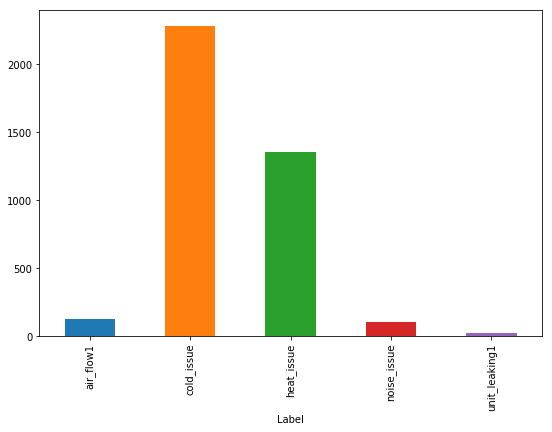

cold_issue       2283
heat_issue       1359
air_flow1         128
noise_issue       104
unit_leaking1      23
Name: Label, dtype: int64


In [119]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,6))
data.groupby('Label').Description.count().plot.bar(ylim=0)
plt.show()

print(data['Label'].value_counts())

In [151]:
data['Assignee_Name'].value_counts().head(25)

WeWork Community team at 27 E 28th St            145
WeWork 88 University Community Management        143
WeWork Community team at 315 W 36th St           129
WeWork Community team at 81 Prospect St          125
WeWork Community team at 500 7th Ave             111
WeWork Community team at 33 Irving Pl            101
Drew Clark                                        97
McKenzie Utter                                    92
WeWork West Broadway Community Management         91
WeWork Community team at 110 Wall St              90
WeWork Community team at 54 W 40th St             88
WeWork Community team at 109 S 5th St             87
WeWork Community team at Security Building        79
Sydney Dymond                                     75
WeWork Community team at 1460 Broadway            72
WeWork Community team at Brickell City Centre     68
WeLive Wall Street Community Management           63
WeWork Houston Galleria Community Management      59
WeWork Community team at 175 Varick St        

In [121]:
"""
Feature Engineering
"""
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [190]:
# Keep AC

ac_keywords = [" AC ", " ac ", "a/c", "A/C", "HVAC", "Hvac", "hvac ", "Air Condition", "Air condition", "air condition"]

def keep_ac(texts,ac_keywords):
    data_description = []
    for text in texts:
        for keyword in ac_keywords:        
            if keyword in text: # actually acceptable
                text = text.replace(keyword," AC ")
        data_description.append(text)
    return data_description
            
data["Description"] = keep_ac(data["Description"], ac_keywords)

data["Description"][1]
    

"Hi,\n\nCan someone please check out our  AC  unit? Only 1 of the 2 in our office work, and the working one is currently blowing cold air. It's quite cold in the office.\n\nThanks!\nMax"

In [123]:
# bag of words
def sent_to_words(texts):
    for text in texts:
        yield(simple_preprocess(text, min_len=2))

data_words = list(sent_to_words(data["Description"]))
print (data_words[3])


# Preparing Stop Words
stop_words = stopwords.words('english')
stop_words.extend(["hi","hey","guys","you","thank","thanks","please","would","could"])
for w in ["on","off","up","down"]:
    stop_words.remove(w)

# Define functions process stopwords & other keywords
def remove_stopwords(texts):
    new_texts=[]
    for text in texts:
        yield([word for word in text if word not in stop_words])

# Remove Stop Words
data_words_nonstops = list(remove_stopwords(data_words))
print(data_words_nonstops[3])

['can', 'you', 'please', 'turn', 'the', 'heat', 'up', 'on', 'it', 'very', 'cold', 'thank', 'you']
['turn', 'heat', 'up', 'on', 'cold']


In [163]:
# Trigram
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, numpy, string

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3),stop_words=stop_words)
features = tfidf.fit_transform(data["Description"]).toarray()
labels = data.Label

features.shape
print("Each of", features.shape[0], "consumer complaint narratives is represented by", features.shape[1], "features")
print("representing the tf-idf score for different unigrams and bigrams")

Each of 3897 consumer complaint narratives is represented by 2320 features
representing the tf-idf score for different unigrams and bigrams


In [164]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Label, Label_id in sorted(Label_to_id.items()):
  features_chi2 = chi2(features, labels == Label)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(Label))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))
  print("")

# 'air_flow1':
  . Most correlated unigrams:
. directly
. ventilation
  . Most correlated bigrams:
. office office
. office up
  . Most correlated trigrams:
. https www google
. google com calendar

# 'cold_issue':
  . Most correlated unigrams:
. cold
. hot
  . Most correlated bigrams:
. cold office
. hot office
  . Most correlated trigrams:
. turn up heat
. turn down heat

# 'heat_issue':
  . Most correlated unigrams:
. cold
. hot
  . Most correlated bigrams:
. make cooler
. hot office
  . Most correlated trigrams:
. turn heat down
. turn down heat

# 'noise_issue':
  . Most correlated unigrams:
. loud
. noise
  . Most correlated bigrams:
. noise coming
. super loud
  . Most correlated trigrams:
. come take look
. turn off fan

# 'unit_leaking1':
  . Most correlated unigrams:
. water
. leaking
  . Most correlated bigrams:
. come check
. radiator office
  . Most correlated trigrams:
. someone come take
. turn on fan



In [126]:
"""
Model Buliding
"""


'\nModel Buliding\n'

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

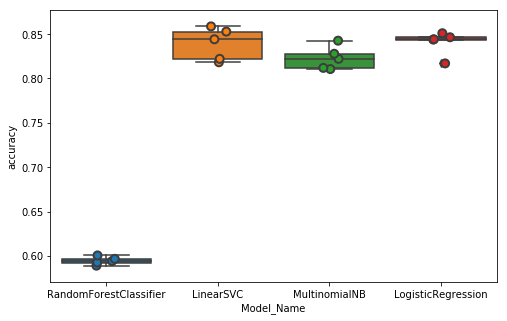

In [185]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  Model_Name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((Model_Name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['Model_Name', 'fold_idx', 'accuracy'])

import seaborn as sns
plt.subplots(figsize=(8,5))

sns.boxplot(x='Model_Name', y='accuracy', data=cv_df, width=0.8)
sns.stripplot(x='Model_Name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [166]:
cv_df.groupby('Model_Name').accuracy.mean()

Model_Name
LinearSVC                 0.839128
LogisticRegression        0.840403
MultinomialNB             0.822930
RandomForestClassifier    0.594566
Name: accuracy, dtype: float64

In [167]:
label_list = ['air_flow1', 'cold_issue', 'heat_issue',  'noise_issue', 'unit_leaking1']

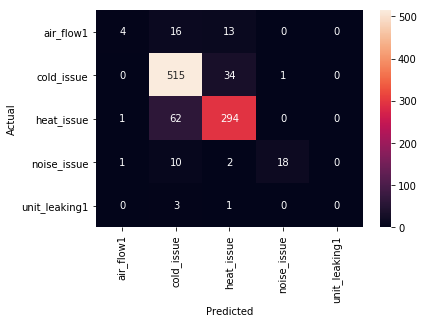

In [173]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.25, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_list, yticklabels=label_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

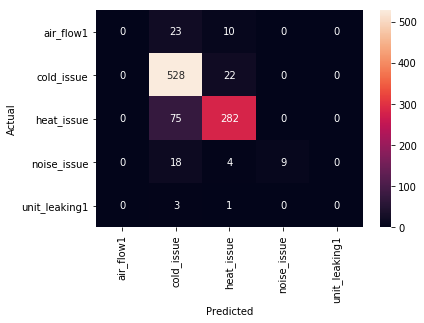

In [174]:
model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.25, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_list, yticklabels=label_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [172]:
table = {"air_flow1": 0,"cold_issue":1, "heat_issue":2,  "noise_issue":3, "unit_leaking1": 4}

In [183]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, label_list))

               precision    recall  f1-score   support

    air_flow1       0.00      0.00      0.00        33
   cold_issue       0.82      0.96      0.88       550
   heat_issue       0.88      0.79      0.83       357
  noise_issue       1.00      0.29      0.45        31
unit_leaking1       0.00      0.00      0.00         4

    micro avg       0.84      0.84      0.84       975
    macro avg       0.54      0.41      0.43       975
 weighted avg       0.82      0.84      0.82       975



C:\Users\szhang7\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\szhang7\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\szhang7\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [181]:
pd.set_option('max_colwidth',150)

from IPython.display import display, HTML
for predicted in label_list:
  for actual in label_list:
        if predicted == actual:
            print("{} predicted as {} : {} examples.".format(actual, predicted, conf_mat[table[actual], table[predicted]]))
            display(data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Label', 'Description']])
            print()

air_flow1 predicted as air_flow1 : 0 examples.


,Label,Description



cold_issue predicted as cold_issue : 528 examples.


,Label,Description
2137,cold_issue,"Hello, \n\nI know that the temperature swings have to make this difficult. Can you make it colder in our office? The big metal pole in the middle ..."
2108,cold_issue,That heater is still blowing cool air so the system has not been fixed from Friday.
1043,cold_issue,It's really cold in our offices. Can we please have the heat turned on?
775,cold_issue,There is extremely cold air blowing in through the vent in my office - its freezing and miserable in here. I've been asking about a solution for a...
1732,cold_issue,"Please adjust my office thermostat to a warmer setting. It is freezing in here each and every day. As space heaters are not allowed, something mus..."
410,cold_issue,"Hi, could you please help our 10th floor room to warm up a little bit?\n\nThanks.\n\nRachel"
3203,cold_issue,"Hello, our office is currently at 68.5 degrees. Would it be possible to warm it up a bit?"
3181,cold_issue,The AC is back on -- it never used to come on this long before and it is chilling out our office.\n\nCan someone please look into this\n\nYesterda...
1943,cold_issue,Our room is extremely cold compared to the rest of the office. Our room # is 11107
2971,cold_issue,"Hello,\n\nThe temperature in the office is too cold, we request the temperature be adjusted to be in the 72-74 range?\n\nThanks,"



heat_issue predicted as heat_issue : 282 examples.


,Label,Description
1947,heat_issue,Super hot in the office again this morning! Something is going on with our heat
2047,heat_issue,"Hello team,\n\nThe occupant of 04E.162 let us know that it's a little warm in their workspace. Could we please have the temperature lowered slight..."
381,heat_issue,Hello! \n\nOccupant in 04.E167.C0 feels that the radiator is too hot. May we have this cooled down? Thanks!\n\nJesse\n0168577246
2330,heat_issue,"It’s a bit warm in the new office (05-127), any chance someone can bump the heat down just a touch?\n\nThanks!\nDane"
841,heat_issue,Hi. Could you please make the Writing Room a bit cooler for us? Thanks so much!
2946,heat_issue,It is very hot in our office currently. Is it possible to lower the temperature?\n\nThanks
3595,heat_issue,it's too hot in our office (11-124). Can we get some cool air pls
3076,heat_issue,"Hi,\nCan you lower the heating to 70-71 degrees? it is 78 at the moment"
3072,heat_issue,"Hello! More air in 419, please! Many thanks."
1174,heat_issue,Please turn down the heat in office 240 thanks



noise_issue predicted as noise_issue : 9 examples.


,Label,Description
3882,noise_issue,The AC in 16-105 is making a pretty loud and distracting hissing sound... Please could someone take a look?
3639,noise_issue,"Please reach out to requester Andy Bean (andybean@) who reported the following:\n\nIssue: Just west of my desk area (08.520.C1), along the ceiling..."
3804,noise_issue,The AC unit in the hallway outside my office makes a weird noise most of the day. It's been like this for a while
2252,noise_issue,"The loud noise and whistling continues in the office, disrupting our work environment."
3169,noise_issue,6th floor AC making squealing noise
436,noise_issue,Loud movie from 2130
3689,noise_issue,White Noise from AC ducting in this office is very loud - to the point where it disrupts phone calls and concentration.\n\nIs there a way to eit...
2306,noise_issue,Intake for AC is super loud in office
3603,noise_issue,Rattling noise coming from AC system in hallway when fan turns on. Seems like something is hitting fan as it is spinning. Goes away when fan tur...



unit_leaking1 predicted as unit_leaking1 : 0 examples.


,Label,Description


In [180]:
pd.set_option('max_colwidth',150)

from IPython.display import display, HTML
for predicted in label_list:
  for actual in label_list:
        if predicted != actual and conf_mat[table[actual], table[predicted]] >= 5:
            print("{} predicted as {} : {} examples.".format(actual, predicted, conf_mat[table[actual], table[predicted]]))
            display(data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Label', 'Description']])
            print()

air_flow1 predicted as cold_issue : 23 examples.


,Label,Description
578,air_flow1,The AC doesn’t work in our office. Our office number is 47
534,air_flow1,What's the best way to increase the temp in our office? The cold draft is freezing out a couple of our staff :) \n\nThank you!
1157,air_flow1,Is it possible to adjust the vent? The air is blowing directly on to my desk. Thanks!
2577,air_flow1,"Hi,\n\nI think over the summer we had our AC ing vent closed to keep the cold air from coming in, but now I think this is preventing hot air from..."
1037,air_flow1,"Hello, \n04.E138 is very cold and has a breeze going through it all of the time (per the customer). \n\nCould we have this space warmed up & the b..."
2885,air_flow1,"Hi, can you please adjust the air on 19 so it is not blowing so much? It’s a very cold constant breeze. \n\nThanks,\nCatherine \n(646) 565-4935"
558,air_flow1,"Hi - the 17th floor is freezing, everyone is sitting here with their winter coats on. Is it possible to turn the temperature up on the 17th floor ..."
3134,air_flow1,"The 129 office heat is on (we think). 129-A is blowing cool air, but not the main 4 desk office space."
3140,air_flow1,"Hi,\n\nCan we please turn off the air in 802 or please raise the temperature.\n\nThank you,\nTina"
1894,air_flow1,Hi. Can you check if heat is on in 1121? It’s cold. Thanks!



heat_issue predicted as cold_issue : 75 examples.


,Label,Description
1875,heat_issue,Burning temperatures here on the 8th floor / Brooklinen Office. Possible to switch off heating?
2404,heat_issue,Hey there! Do I control the heat from my general thermostat? I haven’t been able to get the heat up recently
3793,heat_issue,Hello:\n\nCould you turn up the AC ing a little in the office for today? Today's a bit warmer than normal. I think it should be good if we just...
88,heat_issue,AC is not keeping up or is off. If you guys want to get a feel for the air / heat now is a great time to try it out. We've had the blinds down but...
3126,heat_issue,"Hi,\n\nCould we please have the temp in our space turned up a few degrees?\n\nThanks, \nSara"
953,heat_issue,"Hi Team,\n\nIt has come to our attention that area 04.E104.B0 is too warm. Can we get an engineer out to assist with adjusting the temperature in ..."
1646,heat_issue,The AC keeps blowing cold air even though I put it in heat mode and turn it up to 75 (it’s 67 in my apt now). It also keeps defaulting back to 72 ...
3589,heat_issue,"With higher temps expected tomorrow, we'd like to add AC for tomorrow afternoon's programming on Floor 14. Can you please confirm what time buil..."
720,heat_issue,"Hi folks,\n\nI am on the 3rd floor in the dedicated desk room. I've had to move out today again because of the heat. I thought this issue was reso..."
1663,heat_issue,"Please turn off the blazing heat on the 3rd floor. I have a heater in my office and it has become a sauna in here. Good news is free sauna, bad ne..."



noise_issue predicted as cold_issue : 18 examples.


,Label,Description
977,noise_issue,Hi \n\nThe noise level was back to normal for a couple hours after lunch but it's bad again now.\n\nIf the problem cannot be resolved and if you c...
3888,noise_issue,"The heater/unit fan vent between my office and the lunch room is making a noise as if the blades (or something) are not in alignment. Also, when ..."
1515,noise_issue,The radiator heater on 6 by the elevator is making a crazy air blowing sound suddenly. very loud too- not sure what’s up
615,noise_issue,"Hey team,\n\nCaravel Law has mentioned that the vent in their office sounds like an airplane, may you please look into this as soon as possible?\n..."
1939,noise_issue,"Hello WeWork Support Team,\n\nI informed my local team about this, and Rachel Gartlan instructed me to file a ticket regarding the temperature in ..."
1127,noise_issue,"Hi team,\n\nThe AC duct is rattling in conference room 2A. If you could come to take a look and tighten it that would be great.\n\nThanks,\nChar..."
3446,noise_issue,"Hi Team,\n\nWe just received the following feedback: We are sitting close to YVR15 14.203. Air machinery is humming all day, prevents focus and ca..."
538,noise_issue,Can someone investigate the fan in one of our offices? It's on very high and its quite loud.\n\n-Finale-
1275,noise_issue,The heating unit in our office makes a ton of clanking noise throughout the day. Is there something that can be done to try and fix it?
2656,noise_issue,The screen on the thermostat control in the main living space is showing jumbled symbols and we are unable to see what changes we are making.



air_flow1 predicted as heat_issue : 10 examples.


,Label,Description
3543,air_flow1,"Good afternoon,\n\nIt has been reported that Air isn't flowing in the YVR15 11.317 area. Could you please have a building engineer look into this ..."
2439,air_flow1,Hi Team\n\nPlease adjust the temperature to 71 degrees\n\nthanks\nTCL
85,air_flow1,hey guys can you make it a bit colder in here? really hot in our room
253,air_flow1,"Hola, por favor encender el aire de la 03 122"
453,air_flow1,can we adjust this - its super hot in the offices
2378,air_flow1,Hey guys - there is a meeting in progress in 10E and they are wanting to lower the temp (I imagine it's extra warm because there are a lot of bodi...
295,air_flow1,It's 67.8 degrees in my office on the 11th floor. Can we warm up our end of the hall by a few degrees please?\n\nThanks!\nJennifer
3771,air_flow1,We are in room 05-118. I was wondering if there is any ventilation in this room? It looks like there are vents but nothing blowing out. With ou...
1762,air_flow1,"Hi,\n\nAll heaters in 2109 won’t heat above 64 degrees since yesterday. The air coming out is just cool room temp. \n\nPlease feel free to access ..."
138,air_flow1,"Hi- could you please decrease the airflow a little?Vents appear to be open fully, its a bit loud."



cold_issue predicted as heat_issue : 22 examples.


,Label,Description
1397,cold_issue,Hello - Our office is still incredibly warm. We have fans blowing all day every day. Can you either turn the thermostat down or close the vents in...
528,cold_issue,Can you adjust the set point in our office to 72/74 Degrees? It is currently 67 with constant air movement making it feel colder.
666,cold_issue,"Hello guys,\n\nCan someone please stop bye to discuss live and see what we can do with the AC?\n\nI think the issue is that we are at the end of ..."
668,cold_issue,Can you turn the heat off. It's really hot on the 6th floor.
727,cold_issue,Pleas lower fan thank you!
501,cold_issue,Please please please make 4002 less freeeeeezing.
2626,cold_issue,Warm 6-059
3247,cold_issue,The Nielsen room is very hot right now. The AC may not be working.
530,cold_issue,This office is boiling hot for the second consecutive week. Is this intentional or is something broken? It’s incredibly uncomfortable to be on the...
2733,cold_issue,The room is below 68 degrees and the windows are 55 degrees. Please adjust the heat. The radiators are barely hot and the unit isn't on. thanks
